# Dataprocessing

### imports

In [ ]:
#imports

import numpy as np
import time
import matplotlib.pyplot as plt
import cv2
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import time
import os
import numpy as np
import torchvision
from torchvision import datasets, models
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from collections import defaultdict
from collections import Counter
from math import floor

from PIL import Image, UnidentifiedImageError
import random
from collections import defaultdict

import shutil

import pandas as pd

### Download the Data

In [ ]:
# Install the Kaggle package
!pip install kaggle


In [ ]:
# Make a directory for the Kaggle API key
!mkdir -p ~/.kaggle

# Copy the kaggle.json file to this new directory
!cp kaggle.json ~/.kaggle/

# Change the permissions of the file
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d alex000kim/gc10det

Dataset URL: https://www.kaggle.com/datasets/alex000kim/gc10det
License(s): unknown
100% 921M/926M [00:06<00:00, 163MB/s]
100% 926M/926M [00:06<00:00, 149MB/s]


In [ ]:
!unzip gc10det.zip -d ./data

Archive:  gc10det.zip
  inflating: ./data/1/img_02_425501900_00017.jpg  
  inflating: ./data/1/img_02_425502300_00018.jpg  
  inflating: ./data/1/img_02_425503100_00017.jpg  
  inflating: ./data/1/img_02_425505500_00018.jpg  
  inflating: ./data/1/img_02_425506300_00018.jpg  
  inflating: ./data/1/img_02_425506400_00018.jpg  
  inflating: ./data/1/img_02_425507200_00018.jpg  
  inflating: ./data/1/img_02_425508300_00017.jpg  
  inflating: ./data/1/img_02_425613600_00582.jpg  
  inflating: ./data/1/img_02_425614700_00001.jpg  
  inflating: ./data/1/img_02_425616500_00001.jpg  
  inflating: ./data/1/img_02_425637700_00001.jpg  
  inflating: ./data/1/img_02_425637800_00891.jpg  
  inflating: ./data/1/img_02_425637900_00899.jpg  
  inflating: ./data/1/img_02_425640000_00634.jpg  
  inflating: ./data/1/img_02_425640100_00874.jpg  
  inflating: ./data/1/img_02_425644200_00681.jpg  
  inflating: ./data/1/img_02_425644600_00001.jpg  
  inflating: ./data/1/img_03_3403331900_01545.jpg  
  inflat

In [ ]:
!rm -fr ./data/lable

### Transform for rest of the dataset with rotations etc

In [ ]:
data_dir = "./data"
#Define data augmentation transforms and resize to 244x244
transform = transforms.Compose([
    transforms.Resize((244, 244)), #resize
    transforms.RandomHorizontalFlip(p=0.5), #flip horizontally
    transforms.RandomRotation(15),  #rotate - small angle 15 deg
    transforms.ToTensor(),  #make it a tensor
    transforms.Grayscale(num_output_channels=1),
])


#load dataset (now this has added all the datasets together!!!)
dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transform)

# Augment Data

In [ ]:
np.random.seed(1)

def balance_dataset_with_augmentation(dataset, target_class_size=2000, transform=None):
    class_indices = defaultdict(list)
    for idx, (_, label) in enumerate(dataset):
        class_indices[label].append(idx)

    #transformations
    augmentation_transform = transform or transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10)
    ])


    class_count = 1
    #augment underrepresented classes till 2000
    while class_count < 11:
      for label, indices in class_indices.items():
          class_name = dataset.classes[label]
          path = f"./data/{class_count}"

          #existing images for current class
          class_images = [dataset[i][0] for i in indices]
          current_count = len(class_images)
          images_needed = target_class_size - current_count

          #generate only the required augmented images
          while current_count < target_class_size:
              img = random.choice(class_images)
              augmented_img = augmentation_transform(img)

              img_path = os.path.join(path, f"{class_count}_augmented_{current_count}.png")
              augmented_img_pil = augmented_img if isinstance(augmented_img, Image.Image) else transforms.ToPILImage()(augmented_img)
              augmented_img_pil.save(img_path)

              current_count += 1

          print(f"Augmented images saved in {path} to balance all classes to {target_class_size} samples each.")
          class_count += 1

balance_dataset_with_augmentation(dataset)

dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transform)

Augmented images saved in ./data/1 to balance all classes to 2000 samples each.
Augmented images saved in ./data/2 to balance all classes to 2000 samples each.
Augmented images saved in ./data/3 to balance all classes to 2000 samples each.
Augmented images saved in ./data/4 to balance all classes to 2000 samples each.
Augmented images saved in ./data/5 to balance all classes to 2000 samples each.
Augmented images saved in ./data/6 to balance all classes to 2000 samples each.
Augmented images saved in ./data/7 to balance all classes to 2000 samples each.
Augmented images saved in ./data/8 to balance all classes to 2000 samples each.
Augmented images saved in ./data/9 to balance all classes to 2000 samples each.
Augmented images saved in ./data/10 to balance all classes to 2000 samples each.


# Training test split

In [ ]:
def balanced_train_val_test_split(dataset, test_size=0.15, val_size=0.1765, random_state=42):

    indices = list(range(len(dataset)))
    targets = [label for _, label in dataset.imgs]

    unique_classes = np.unique(targets)

    class_counts = Counter(targets)
    min_class_samples = min(class_counts.values())

    train_indices = []
    val_indices = []
    test_indices = []

    for cls in unique_classes:

        class_indices = [i for i, label in enumerate(targets) if label == cls]

        np.random.seed(random_state)
        class_indices = np.random.choice(class_indices, min_class_samples, replace=False)

        cls_temp_indices, cls_test_indices = train_test_split(
            class_indices,
            test_size=test_size,
            random_state=random_state
        )

        cls_train_indices, cls_val_indices = train_test_split(
            cls_temp_indices,
            test_size=val_size,
            random_state=random_state
        )

        train_indices.extend(cls_train_indices)
        val_indices.extend(cls_val_indices)
        test_indices.extend(cls_test_indices)

    train_set = Subset(dataset, train_indices)
    val_set = Subset(dataset, val_indices)
    test_set = Subset(dataset, test_indices)

    return train_set, val_set, test_set

train_set, val_set, test_set = balanced_train_val_test_split(dataset)

batch_size = 8
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [ ]:
print(f"Training set size: {len(train_set)} images")
print(f"Validation set size: {len(val_set)} images")
print(f"Test set size: {len(test_set)} images")

Training set size: 10950 images
Validation set size: 2350 images
Test set size: 2350 images


In [ ]:
#check the split for each class - ran once to check (hidden for efficiency)

def get_class_distribution(sub_set, full_dataset):
    #extract labels from the sub_set
    labels = [label for _, label in sub_set]
    #count each label
    class_counts = Counter(labels)
    #map label indices to class names
    class_distribution = {full_dataset.classes[label]: count for label, count in class_counts.items()}
    return class_distribution

print("Class distribution in the training set:", get_class_distribution(train_set, dataset))
print("Class distribution in the validation set:", get_class_distribution(val_set, dataset))
print("Class distribution in the test set:", get_class_distribution(test_set, dataset))

Class distribution in the training set: {'1': 1095, '10': 1095, '2': 1095, '3': 1095, '4': 1095, '5': 1095, '6': 1095, '7': 1095, '8': 1095, '9': 1095}
Class distribution in the validation set: {'1': 235, '10': 235, '2': 235, '3': 235, '4': 235, '5': 235, '6': 235, '7': 235, '8': 235, '9': 235}
Class distribution in the test set: {'1': 235, '10': 235, '2': 235, '3': 235, '4': 235, '5': 235, '6': 235, '7': 235, '8': 235, '9': 235}


# Training and Model

In [ ]:
def get_accuracy(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in data_loader:

            imgs = imgs.to(device)
            labels = labels.to(device)

            output = model(imgs)
            # select index with maximum prediction score
            _, pred = torch.max(output, 1)
            correct += (pred == labels).sum().item()
            total += labels.size(0)
    return correct / total

In [ ]:
class VGGMetalDefectCNN(nn.Module):
    def __init__(self, num_classes=10, input_channels=1):
        super(VGGMetalDefectCNN, self).__init__()

        self.features = nn.Sequential(
            #block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            #block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            #block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            #block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            #block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.feature_size = self._get_feature_size(input_channels)

        #fully connected layers
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.feature_size, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, num_classes)
        )

    def _get_feature_size(self, input_channels):
            test_input = torch.zeros(1, input_channels, 244, 244)
            features = self.features(test_input)
            return features.view(1, -1).size(1)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
model2 = VGGMetalDefectCNN()

In [ ]:
def train(model, train_loader, val_loader, num_epochs, learning_rate):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_acc = []
    val_acc = []
    train_loss = []
    val_loss = []

    print("Training Started...")

    #use gpu
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0

        for imgs, labels in train_loader:

            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            running_train_loss += loss.item()

        train_loss.append(running_train_loss / len(train_loader))

        train_acc_epoch = get_accuracy(model, train_loader, device)
        val_acc_epoch = get_accuracy(model, val_loader, device)

        train_acc.append(train_acc_epoch)
        val_acc.append(val_acc_epoch)

        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for val_imgs, val_labels in val_loader:
                val_imgs = val_imgs.to(device)
                val_labels = val_labels.to(device)

                val_outputs = model(val_imgs)
                val_loss_item = criterion(val_outputs, val_labels)
                running_val_loss += val_loss_item.item()

        val_loss.append(running_val_loss / len(val_loader))

        print(f"Epoch {epoch + 1}: Train Accuracy: {train_acc_epoch:.4f}, Train Loss: {train_loss[epoch]:.4f}, "
              f"Validation Accuracy: {val_acc_epoch:.4f}, Validation Loss: {val_loss[epoch]:.4f}")

    print("Finished Training")

    epochs = np.arange(1, num_epochs + 1)
    return train_acc, val_acc, train_loss, val_loss, epochs


In [ ]:
train_acc, val_acc, train_loss, val_loss, epochs = train(model2,train_loader, val_loader, 35, 0.0001)

Training Started...
Epoch 1: Train Accuracy: 0.2034, Train Loss: 2.2145, Validation Accuracy: 0.1962, Validation Loss: 2.1652
Epoch 2: Train Accuracy: 0.2549, Train Loss: 2.0700, Validation Accuracy: 0.2485, Validation Loss: 2.0135
Epoch 3: Train Accuracy: 0.4316, Train Loss: 1.8272, Validation Accuracy: 0.4217, Validation Loss: 1.5573
Epoch 4: Train Accuracy: 0.5401, Train Loss: 1.4753, Validation Accuracy: 0.5238, Validation Loss: 1.3014
Epoch 5: Train Accuracy: 0.5960, Train Loss: 1.2697, Validation Accuracy: 0.5757, Validation Loss: 1.1780
Epoch 6: Train Accuracy: 0.6359, Train Loss: 1.1189, Validation Accuracy: 0.6204, Validation Loss: 1.0400
Epoch 7: Train Accuracy: 0.6609, Train Loss: 0.9962, Validation Accuracy: 0.6396, Validation Loss: 0.9858
Epoch 8: Train Accuracy: 0.7147, Train Loss: 0.9110, Validation Accuracy: 0.6885, Validation Loss: 0.8573
Epoch 9: Train Accuracy: 0.7595, Train Loss: 0.8366, Validation Accuracy: 0.7362, Validation Loss: 0.7609
Epoch 10: Train Accuracy: 

In [ ]:
train_acc, val_acc, train_loss, val_loss, epochs = train(model2,train_loader, val_loader, 35, 0.0001)

Training Started...
Epoch 1: Train Accuracy: 0.2733, Train Loss: 2.1836, Validation Accuracy: 0.2766, Validation Loss: 1.9422
Epoch 2: Train Accuracy: 0.4574, Train Loss: 1.7256, Validation Accuracy: 0.4574, Validation Loss: 1.4476
Epoch 3: Train Accuracy: 0.5492, Train Loss: 1.4313, Validation Accuracy: 0.5409, Validation Loss: 1.2344
Epoch 4: Train Accuracy: 0.6321, Train Loss: 1.2467, Validation Accuracy: 0.6106, Validation Loss: 1.0929
Epoch 5: Train Accuracy: 0.6359, Train Loss: 1.1051, Validation Accuracy: 0.6183, Validation Loss: 1.0101
Epoch 6: Train Accuracy: 0.7120, Train Loss: 0.9853, Validation Accuracy: 0.6830, Validation Loss: 0.8956
Epoch 7: Train Accuracy: 0.7288, Train Loss: 0.9006, Validation Accuracy: 0.6996, Validation Loss: 0.8320
Epoch 8: Train Accuracy: 0.7584, Train Loss: 0.8260, Validation Accuracy: 0.7285, Validation Loss: 0.7467
Epoch 9: Train Accuracy: 0.7690, Train Loss: 0.7727, Validation Accuracy: 0.7409, Validation Loss: 0.7186
Epoch 10: Train Accuracy: 

# Training Plots

In [ ]:
plt.plot(epochs, train_acc, label="Training Accuracy", color='blue')
plt.plot(epochs, val_acc, label="Validation Accuracy", color='orange')
plt.title("Training vs. Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'plt' is not defined

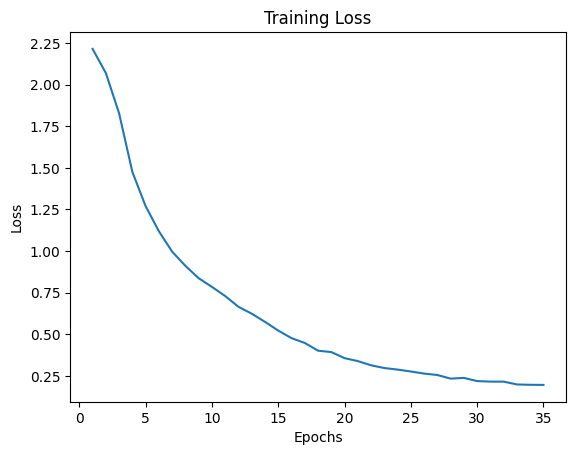

In [ ]:
    plt.title("Training Loss")
    plt.plot(epochs, train_loss, label="Train")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

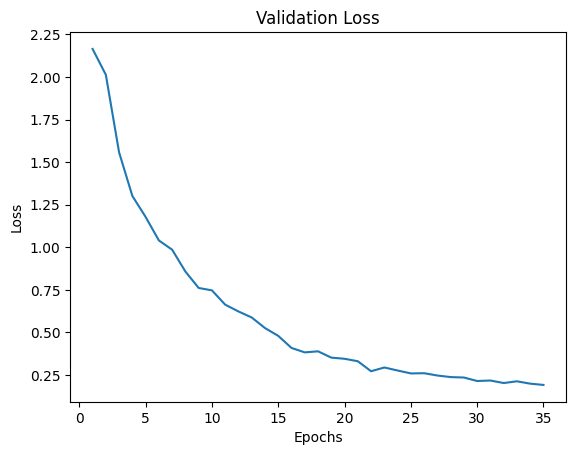

In [ ]:
    plt.title("Validation Loss")
    plt.plot(epochs, val_loss, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

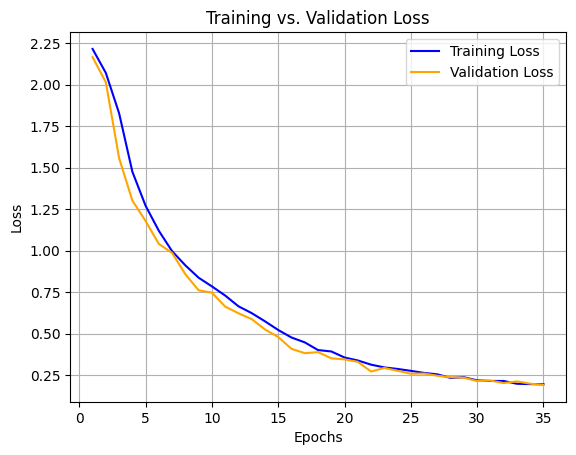

In [ ]:
plt.plot(epochs, train_loss, label="Training Loss", color='blue')
plt.plot(epochs, val_loss, label="Validation Loss", color='orange')
plt.title("Training vs. Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Testing Accuracy

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
get_accuracy(model2, test_loader,device)

0.9370212765957446

The models test accuracy is 93%

# Confusion Matrix/Accuracy/Precison

In [ ]:

def compute_metrics(model, data_loader, device, class_names):

    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    cm = confusion_matrix(all_labels, all_predictions)
    print("Confusion Matrix:\n", cm)

    accuracy = accuracy_score(all_labels, all_predictions)

    metrics = {}
    for i, class_name in enumerate(class_names):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = cm.sum() - (TP + FN + FP)

        precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

        metrics[class_name] = {
            "TP": TP,
            "FN": FN,
            "FP": FP,
            "TN": TN,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1
        }

    return accuracy, metrics

class_names = ['Punching Hole', 'Waist Folding', 'Welding Line', 'Crescent Gap', 'Water Spot', 'Oil Spot', 'Silk Spot', 'Inclusion', 'Rolled Pit', 'Crease']  # Replace with your class labels
accuracy, metrics = compute_metrics(model2, test_loader, device, class_names)

print("Overall Accuracy:", accuracy)
for class_name, metric in metrics.items():
    print(f"\nClass: {class_name}")
    for key, value in metric.items():
        print(f"  {key}: {value}")


Confusion Matrix:
 [[232   0   1   1   0   0   0   1   0   0]
 [  0 232   1   0   0   0   0   0   0   2]
 [  0  14 211  10   0   0   0   0   0   0]
 [ 16   0  10 200   7   0   0   0   0   2]
 [  0   0   0   7 221   5   0   2   0   0]
 [  0   0   0   2   5 221   2   3   0   2]
 [  0   1   0   0   1   5 218   7   3   0]
 [  0   1   0   0   2   2   4 221   5   0]
 [  0   0   0   0   1   0   3   9 218   4]
 [  0   1   0   0   0   0   0   0   0 234]]
Overall Accuracy: 0.9395744680851064

Class: Punching Hole
  TP: 232
  FN: 3
  FP: 16
  TN: 2099
  Precision: 0.9354838709677419
  Recall: 0.9872340425531915
  F1 Score: 0.9606625258799171

Class: Waist Folding
  TP: 232
  FN: 3
  FP: 17
  TN: 2098
  Precision: 0.9317269076305221
  Recall: 0.9872340425531915
  F1 Score: 0.9586776859504132

Class: Welding Line
  TP: 211
  FN: 24
  FP: 12
  TN: 2103
  Precision: 0.9461883408071748
  Recall: 0.8978723404255319
  F1 Score: 0.9213973799126638

Class: Crescent Gap
  TP: 200
  FN: 35
  FP: 20
  TN: 20

# Testing random images

In [ ]:

class_names = ['Punching Hole', 'Waist Folding', 'Welding Line', 'Crescent Gap', 'Water Spot',
               'Oil Spot', 'Silk Spot', 'Inclusion', 'Rolled Pit', 'Crease']

def test_random_images(model, test_loader, device, num_batches=5):
    model.eval()
    fig, axes = plt.subplots(1, num_batches, figsize=(15, 3))

    with torch.no_grad():
        selected_images = []
        selected_labels = []

        batch_indices = torch.randperm(len(test_loader))[:num_batches]

        for i, batch_idx in enumerate(batch_indices):

            for j, (images, labels) in enumerate(test_loader):
                if j == batch_idx:

                    random_index = torch.randint(0, len(images), (1,)).item()
                    selected_images.append(images[random_index])
                    selected_labels.append(labels[random_index].item())
                    break

        selected_images = torch.stack(selected_images)
        selected_labels = torch.tensor(selected_labels)

        for i, image in enumerate(selected_images):
            true_label = class_names[selected_labels[i]]

            image_input = image.unsqueeze(0).to(device)
            model_output = model(image_input)
            _, predicted_idx = torch.max(model_output, 1)
            predicted_label = class_names[predicted_idx.item()]

            image = image.permute(1, 2, 0)
            image = (image - image.min()) / (image.max() - image.min())

            axes[i].imshow(image)
            axes[i].set_title(f'True: {true_label}\nPred: {predicted_label}')
            axes[i].axis('off')

    plt.tight_layout()
    plt.show()


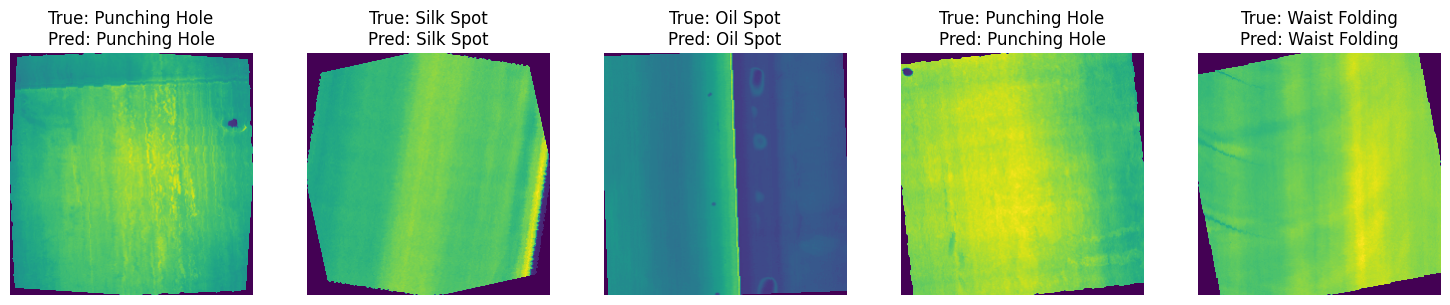

In [ ]:
test_random_images(model2, test_loader, device)

In [ ]:
test_random_images(model2, test_loader, device)

NameError: name 'model2' is not defined

In [ ]:
test_random_images(model2, test_loader, device)

NameError: name 'test_random_images' is not defined

In [ ]:

class_names = ['Punching Hole', 'Waist Folding', 'Welding Line', 'Crescent Gap', 'Water Spot',
               'Oil Spot', 'Silk Spot', 'Inclusion', 'Rolled Pit', 'Crease']
def test_random_images2(model, data_loader, num_samples=5, device):

    model.eval()
    model.to(device)

    all_samples = []
    all_labels = []
    for images, labels in data_loader:
        all_samples.extend(images)
        all_labels.extend(labels)

    all_samples = torch.stack(all_samples)
    all_labels = torch.tensor(all_labels)

    indices = random.sample(range(len(all_samples)), num_samples)
    selected_images = all_samples[indices]
    selected_labels = all_labels[indices]

    print(f"{'Sample':<10}{'Actual':<20}{'Predicted':<20}")

    for i, (image, label) in enumerate(zip(selected_images, selected_labels)):

        input_image = image.unsqueeze(0).to(device)
        label = label.to(device)

        with torch.no_grad():
            output = model(input_image)
            _, predicted = torch.max(output, 1)

        actual_class = class_names[label.item()]
        predicted_class = class_names[predicted.item()]

        line = str(i + 1) + " " * (10 - len(str(i + 1)))
        line += actual_class + " " * (20 - len(actual_class))
        line += predicted_class + " " * (20 - len(predicted_class))

        print(line)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_random_images2(model2, val_loader, 10,  device)

Sample    Actual              Predicted           
--------------------------------------------------
1         Crescent Gap        Crescent Gap        
2         Crease              Crease              
3         Rolled Pit          Rolled Pit          
4         Crescent Gap        Crescent Gap        
5         Silk Spot           Silk Spot           
6         Punching Hole       Punching Hole       
7         Silk Spot           Silk Spot           
8         Welding Line        Welding Line        
9         Water Spot          Water Spot          
10        Silk Spot           Silk Spot           


In [ ]:
test_random_images2(model2, test_loader, 10,  device)

Sample    Actual              Predicted           
--------------------------------------------------
1         Crescent Gap        Crescent Gap        
2         Water Spot          Crescent Gap        
3         Welding Line        Crescent Gap        
4         Inclusion           Inclusion           
5         Waist Folding       Waist Folding       
6         Silk Spot           Silk Spot           
7         Water Spot          Water Spot          
8         Inclusion           Inclusion           
9         Crease              Crease              
10        Inclusion           Inclusion           
